[SWAI] Backend Stock Data MachineLearning - Notebook
====

https://dk-kang.tistory.com/entry/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EC%A3%BC%EA%B0%80-%EC%98%88%EC%B8%A1-%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%A8-%EB%A7%8C%EB%93%A4%EA%B8%B0 <br>
https://sosoeasy.tistory.com/332 <br>
https://sosoeasy.tistory.com/333 <br>
https://sosoeasy.tistory.com/334 <br>

In [66]:
import tensorflow.keras as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import FinanceDataReader as fdr
import os
import sklearn.preprocessing as skl
# skl.MinMaxScaler skl.StandarkScaler

***

# 0. First Settings

### 0.1. Make Directory 

In [67]:
# True: Input the Directory that already exists in function 'directory'
# False: Make New Directory named the current time
using_exist_data = True

# ./SDML_Datas/{str:already_dir_DATE}/{str:already_dir_TIME}-{int:already_dir_COUNT}
# if You can't see already_dir_COUNT value in directory, input 0 in already_dir_COUNT
already_dir_DATE = "20210708"
already_dir_TIME = "225041"
already_dir_COUNT = 0

In [68]:
dir_date = ""
dir_time = ""
dir_count = 0
directory = ""

if not os.path.exists("./SDML_Datas"):
        os.mkdir("./SDML_Datas")

if using_exist_data:
    dir_date = already_dir_DATE
    dir_time = already_dir_TIME
    dir_count = already_dir_COUNT
    directory = "./SDML_Datas/{}/{}".format(dir_date, dir_time)
    if not dir_count == 0:
        directory = directory + "-{}".format(dir_count)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
else:
    dir_date = dt.date.today().strftime("%Y%m%d")
    dir_time = dt.datetime.now().strftime("%H%M%S")
    if not os.path.exists("./SDML_Datas/{}".format(dir_date)):
        os.mkdir("./SDML_Datas/{}".format(dir_date))
    if not os.path.exists("./SDML_DATAS/{}/{}".format(dir_date, dir_time)):
        os.mkdir("./SDML_DATAS/{}/{}".format(dir_date, dir_time))
    else:
        directory = "./SDML_Datas/{}/{}".format(dir_date, dir_time)
        while os.path.exists(directory):
            dir_count += 1
            directory = "./SDML_DATAS/{}/{}-{}".format(dir_date, dir_time, dir_count)

***

# 1. Crawling Finace datas

+ Exchange and Index lists: <br>
    https://github.com/FinanceData/FinanceDataReader/wiki/Quick-Reference


### 1.1. Stock datas

In [69]:
stock_symbol = "005930" #type: str("Symbol Here")
stock_exchange = "KRX" #type: str("code Here")
stock_crawling_start_date = "2015-01-01" #type: str("yyyy-MM-dd")
stock_crawling_end_date = "today" #type: str("yyyy-MM-dd") or str("today"): today date

In [70]:
directory_csv = ""
directory_csv_count = 0

if stock_crawling_end_date == "today":
    stock_crawling_end_date = dt.date.today().strftime("%Y-%m-%d")
dataframe = pd.DataFrame(fdr.DataReader(stock_symbol, stock_crawling_start_date, stock_crawling_end_date, exchange = stock_exchange))
directory_csv = directory + "/{}{}-{}-{}.csv".format(stock_exchange, stock_symbol, stock_crawling_start_date, stock_crawling_end_date)
while os.path.exists(directory_csv):
    directory_csv_count += 1
    directory_csv = directory + "/{}{}-{}-{}-{}.csv".format(stock_exchange, stock_symbol, stock_crawling_start_date, stock_crawling_end_date, str(directory_csv_count))
dataframe.to_csv(directory_csv)

***

# 2. Data Analysis

In [71]:
dataframe.insert(len(dataframe.columns), "Mid", (dataframe["High"] + dataframe["Low"]) / 2)
dataframe.insert(len(dataframe.columns), "MA5", dataframe["Close"].rolling(window = 5).mean())
dataframe.insert(len(dataframe.columns), "MA20", dataframe["Close"].rolling(window = 20).mean())
dataframe.insert(len(dataframe.columns), "MA60", dataframe["Close"].rolling(window = 60).mean())
dataframe.insert(len(dataframe.columns), "MA120", dataframe["Close"].rolling(window = 120).mean())
dataframe.insert(len(dataframe.columns), "Tomorrow Close", dataframe["Close"].shift(-1))
dataframe.insert(len(dataframe.columns), "Fluctuation", dataframe["Tomorrow Close"] - dataframe["Close"])
dataframe.insert(len(dataframe.columns), "Fluctuation Rate", dataframe["Fluctuation"] / dataframe["Close"])

In [72]:
dataframe_columns = ["Date", "Open", "High", "Low", "Close", "Volume", "Change", "Mid", "MA5", "MA20", "MA60", "MA120", "Tomorrow Close", "Fluctuation", "Fluctuation Rate"]
dataframe_dates = dataframe.iloc[:, [0]]

directory_csv_edited = directory + "/{}{}-{}-{}-Edited.csv".format(stock_exchange, stock_symbol, stock_crawling_start_date, stock_crawling_end_date)
directory_csv_edited_count = 0
while os.path.exists(directory_csv_edited):
    directory_csv_edited_count += 1
    directory_csv_edited = directory + "/{}{}-{}-{}-{}-Edited-{}.csv".format(stock_exchange, stock_symbol, stock_crawling_start_date, stock_crawling_end_date, str(directory_csv_count), str(directory_csv_edited_count))
dataframe.to_csv(directory_csv_edited)

In [79]:
MinMax_Scaler = skl.MinMaxScaler()
MinMax_Scaler.fit(dataframe)
dataframe_mm = MinMax_Scaler.transform(dataframe)
dataframe_mm = pd.DataFrame(dataframe_mm, columns = dataframe_columns[1:])

In [80]:
train_size_percentage = 60
test_size_percentage = 30
validation_size_percentage = 10

In [84]:
train_size = int(len(dataframe_mm) * (train_size_percentage / 100))
test_size = int(len(dataframe_mm) * (test_size_percentage / 100))
train_x = np.array(dataframe_mm[:train_size])
train_y = np.array(dataframe_mm['Close'][:train_size])
test_x = np.array(dataframe_mm[train_size:test_size + train_size])
test_y = np.array(dataframe_mm['Close'][train_size:test_size + train_size])
validation_x = np.array(dataframe_mm[test_size + train_size:])
validation_y = np.array(dataframe_mm['Close'][test_size + train_size:])

# 3. Learning

In [88]:
learning_rate = 0.01
epochs = 500
batch_size = 100
input_size = 8

model = tf.Sequential()
model.add(tf.layers.Dense(input_size, activation='tanh', input_shape = (train_x.shape[1],)))
model.add(tf.layers.Dense(input_size * 3, activation = 'tanh'))
model.add(tf.layers.Dense(1, activation='tanh'))
model.compile(optimizer='sgd', loss='mse', metrics=['mae', 'mape','acc']) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 120       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [89]:
history = model.fit(train_x, train_y, epochs=training_cnt, batch_size=batch_size, verbose=1)
val_mse, val_mae, val_mape, val_acc = model.evaluate(test_x, test_y, verbose=0)

Epoch 1/500
10/10 [==============================] - 0s 1ms/step - loss: nan - mae: nan - mape: nan - acc: 0.0021
Epoch 2/500
10/10 [==============================] - 0s 1ms/step - loss: nan - mae: nan - mape: nan - acc: 0.0021
Epoch 3/500
10/10 [==============================] - 0s 1ms/step - loss: nan - mae: nan - mape: nan - acc: 0.0021
Epoch 4/500
10/10 [==============================] - 0s 1ms/step - loss: nan - mae: nan - mape: nan - acc: 0.0021
Epoch 5/500
10/10 [==============================] - 0s 1ms/step - loss: nan - mae: nan - mape: nan - acc: 0.0021
Epoch 6/500
10/10 [==============================] - 0s 997us/step - loss: nan - mae: nan - mape: nan - acc: 0.0021
Epoch 7/500
10/10 [==============================] - 0s 997us/step - loss: nan - mae: nan - mape: nan - acc: 0.0021
Epoch 8/500
10/10 [==============================] - 0s 995us/step - loss: nan - mae: nan - mape: nan - acc: 0.0021
Epoch 9/500
10/10 [==============================] - 0s 776us/step - loss: nan - m

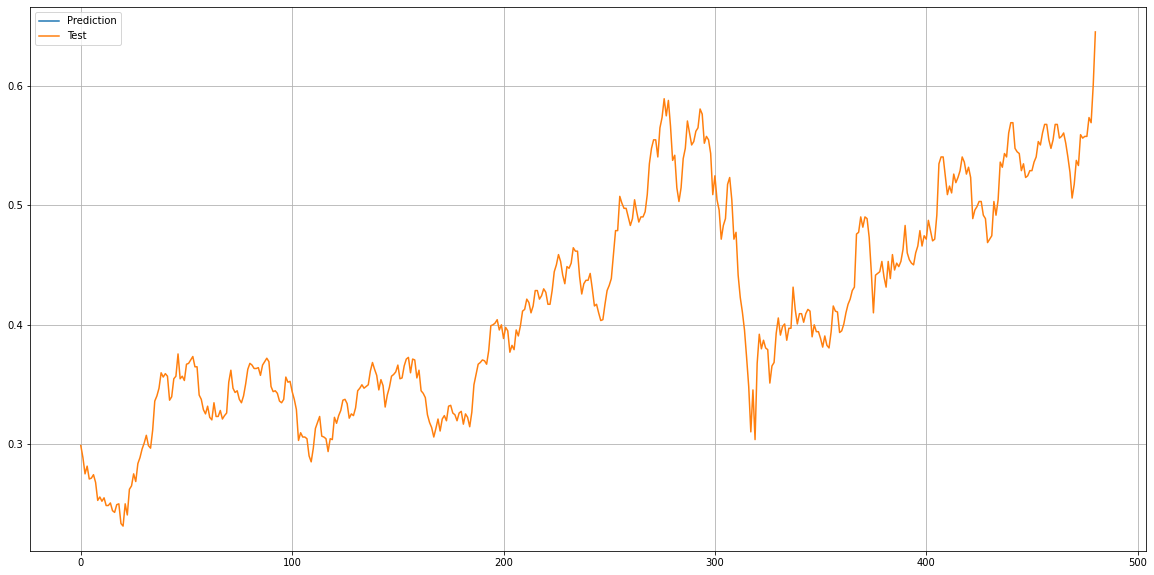

In [97]:
prediction = model.predict(test_x)

plt.figure(figsize = (20, 10)) 
plt.plot(prediction, label = "Prediction")
plt.plot(test_y, label="Test")
plt.legend()
plt.grid()
plt.show()

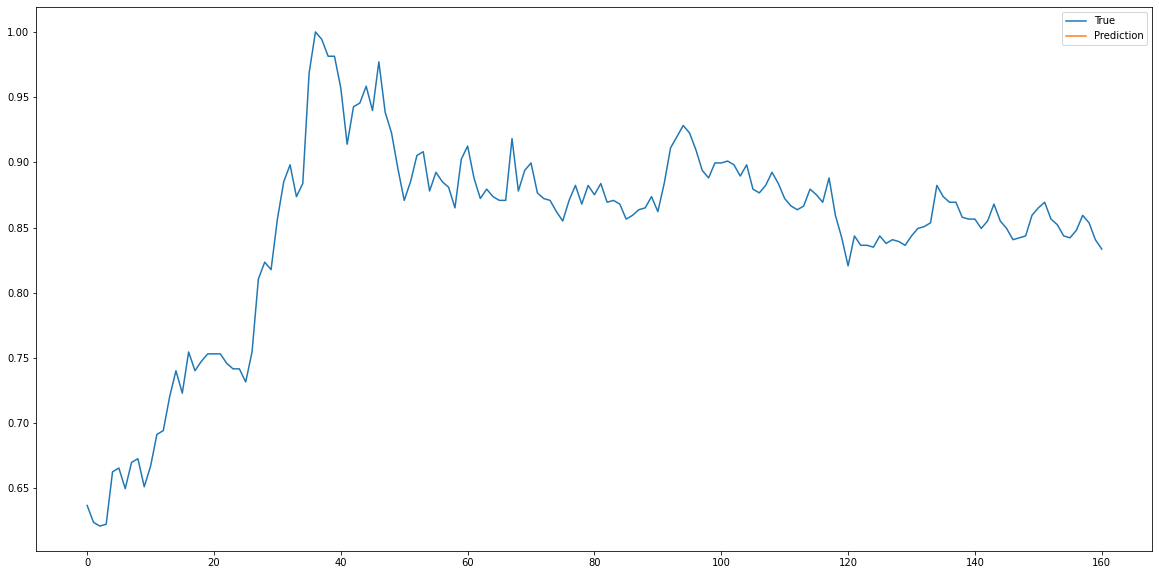

In [92]:
pred = model.predict(validation_x)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(validation_y, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

# -1. Data Visualization

### Table

In [74]:
dataframe

,Open,High,Low,Close,Volume,Change,Mid,MA5,MA20,MA60,MA120,Tomorrow Close,Fluctuation,Fluctuation Rate
0,0.296777,0.276849,0.296536,0.075510,0.001943,0.446431,0.286307,NaN,NaN,NaN,NaN,0.076371,0.343820,0.446403
1,0.295903,0.276033,0.293408,0.076371,0.002246,0.446403,0.284380,NaN,NaN,NaN,NaN,0.065461,0.251685,0.280175
2,0.291251,0.272107,0.287821,0.065461,0.003374,0.280175,0.279656,NaN,NaN,NaN,NaN,0.068906,0.364045,0.484287
3,0.286600,0.270868,0.286480,0.068906,0.003172,0.484287,0.278368,NaN,NaN,NaN,NaN,0.070916,0.352809,0.463155
4,0.296567,0.276653,0.292726,0.070916,0.003206,0.463155,0.284375,0.070456,NaN,NaN,NaN,0.070916,0.337079,0.434215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,0.887043,0.834711,0.893855,0.847832,0.092252,0.461233,0.863124,0.860957,0.908836,0.957238,0.996062,0.859317,0.426966,0.487982
1601,0.892580,0.838843,0.899441,0.859317,0.134339,0.487982,0.867955,0.861541,0.908294,0.956580,0.994726,0.853575,0.292135,0.407596
1602,0.899225,0.839876,0.897207,0.853575,0.177089,0.407596,0.867418,0.861833,0.908061,0.955923,0.993461,0.840655,0.235955,0.374027
1603,0.898117,0.838843,0.892737,0.840655,0.184495,0.374027,0.864734,0.861249,0.907209,0.954800,0.992067,0.833477,0.280899,0.400400


### Candle

In [76]:
bokeh_plot_title = "{} - {} {} ( from {} to {} ) [ {} ]".format(dt.datetime.now().strftime("%Y%m%d%H%M%S"), stock_exchange, stock_symbol, stock_crawling_start_date, stock_crawling_end_date, directory)
fdr.chart.config(config = {"title": bokeh_plot_title, "width": 960, "height": 480, "volume": True})
fdr.chart.plot(dataframe)

Loading BokehJS ...

AttributeError: 'int' object has no attribute 'strftime'

### Moving Average Line

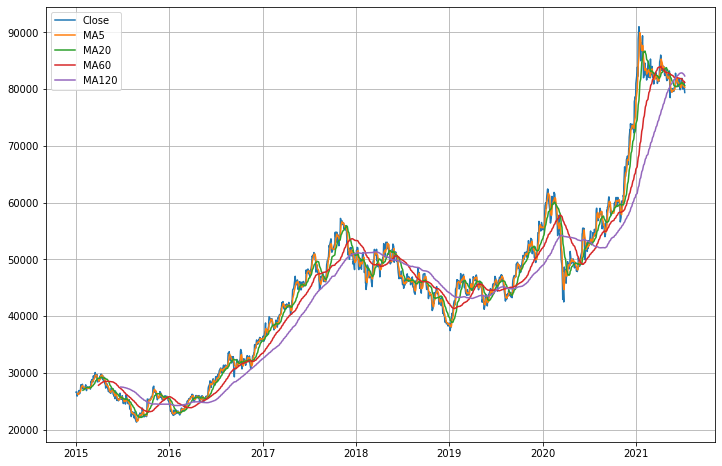

In [ ]:
plt.figure(figsize=(12,8)) 
plt.plot(dataframe['Close'], label="Close")
plt.plot(dataframe['MA5'], label="MA5")
plt.plot(dataframe['MA20'], label="MA20")
plt.plot(dataframe['MA60'], label="MA60")
plt.plot(dataframe['MA120'], label="MA120")
plt.legend(loc = 'best')
plt.grid()
plt.show()

### Fluctuation Rate

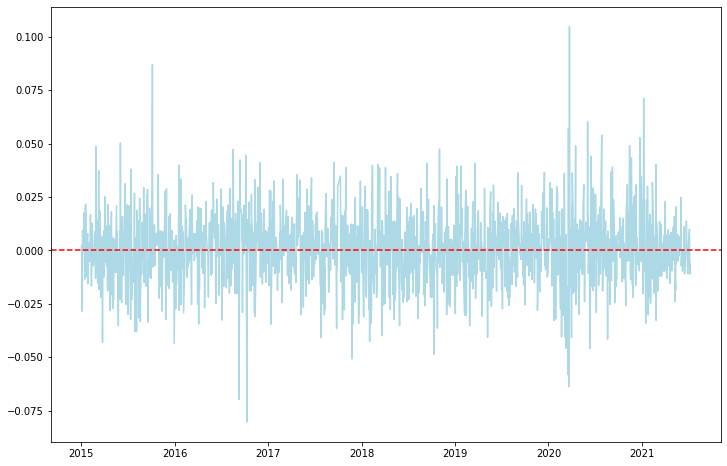

In [ ]:
plt.figure(figsize = (12, 8)) 
plt.plot(dataframe.index, dataframe['Fluctuation Rate'], color = 'lightblue')
plt.axhline(y = 0, color = 'red', ls = '--')
plt.show()

Text(0.5, 1.0, 'Fluctuation Rate Histogram')

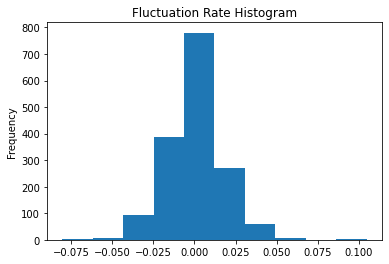

In [ ]:
dataframe['Fluctuation Rate'].plot.hist()
plt.title('Fluctuation Rate Histogram')